In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(585, 455, 3)


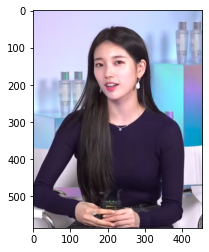

In [19]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/CV_Ex_Data/images/img.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
# DeepLab 모델 준비(PixelLib)
model_dir = os.getenv('HOME')+'/aiffel/CV_Ex_Data/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/CV_Ex_Data/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7252dfbf7100>)

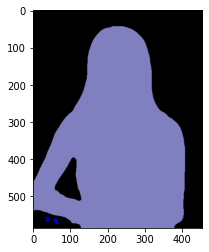

21

In [34]:
# 세그멘테이션 모델 생성
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file)

# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

# 이미지 분할 결과 출력
plt.imshow(output)
plt.show()

# PASCAL VOC 데이터 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

In [25]:
# 이미지 분할 결과값 출력
segvalues

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [26]:
# 분할 결과에 어떤 물체가 담겨있는지 확인
# 이미지 분할 결과 라벨 확인
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


In [27]:
# 각 데이터 라벨에 할당된 색상값 확인
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [35]:
colormap[15]    # person 라벨에 해당하는 색상값

array([192, 128, 128])

(585, 455)


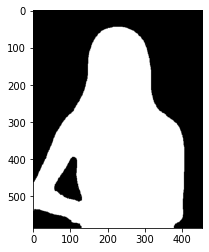

In [29]:
seg_color = (128,128,192)   # person라벨 색상값 RGB순서 BGR로 변경

# person만 분리하는 마스크 만들기
# seg_color와 같으면 1, 다르면 0
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

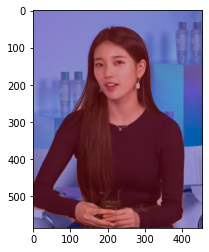

In [30]:
# 원본 이미지와 마스크 이미지 합쳐서 보기
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255   # 마스크 값이 1이면 255, 0이면 0

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # 255와 0을 적당한 색상으로 변경

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0) # 이미지 합치기

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

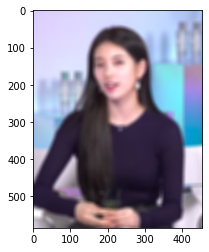

In [31]:
# 이미지 흐리게 만들기
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

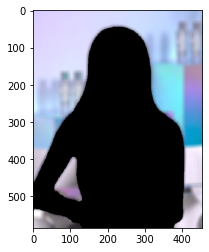

In [32]:
# 흐린 이미지에서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # BGR을 RGB로

img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전 : 배경 0, 사람 255 -> 배경 255, 사람 0

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 사람에 해당하는 픽셀의 색상값 0으로

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

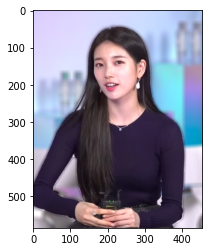

In [33]:
# 배경(흐린 이미지)과 사람(원본 이미지) 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))  # BGR -> RGB
plt.show()

### 함수화 후 테스트 진행 ↓

In [4]:
# DeepLab 모델 준비(PixelLib)
model_dir = os.getenv('HOME')+'/aiffel/CV_Ex_Data/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file)

# 세그멘테이션 모델 생성
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file)

# PASCAL VOC 데이터 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# 라벨의 컬러맵
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [5]:
def portrait(img_path, label_name):
    plt.figure(figsize=(10, 4))
    
    # 이미지 불러오기 
    img_orig = cv2.imread(img_path) 
    print(img_orig.shape)

    # 모델에 이미지 입력
    segvalues, output = model.segmentAsPascalvoc(img_path)

    # 이미지 분할 결과 어떤 물체가 담겨있는지 확인
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])
    
    # 라벨 색상 값
    idx = LABEL_NAMES.index(label_name)
    seg_color_rgb = colormap[idx]
    seg_color = tuple(colormap[idx][::-1])

    # person만 분리하는 마스크 만들기
    seg_map = np.all(output==seg_color, axis=-1) 
    print(seg_map.shape) 
    plt.subplot(1, 2, 1)
    plt.imshow(seg_map, cmap='gray')
    #plt.show()
    
    # 원본 이미지와 마스크 이미지 합쳐서 보기
    img_show = img_orig.copy()
    img_mask = seg_map.astype(np.uint8) * 255   # 마스크 값이 1이면 255, 0이면 0
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # 255와 0을 적당한 색상으로 변경
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0) # 이미지 합치기
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return img_orig, img_mask

In [6]:
def background_blur(img_orig, img_mask):
    plt.figure(figsize=(10, 4))
    
    # 이미지 흐리게 만들기
    img_orig_blur = cv2.blur(img_orig, (13,13))

    # 흐린 이미지에서 배경만 추출
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # BGR을 RGB로
    img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전 : 배경 0, 사람 255 -> 배경 255, 사람 0
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 사람에 해당하는 픽셀의 색상값 0으로
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    # 배경과 원본 이미지 합치기
    plt.figure(figsize=(10, 4))
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.title("original")
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))  # BGR -> RGB
    plt.title("blur")
    plt.show()
    
def background_chromakey(img_orig, img_mask, bg_path):
    plt.figure(figsize=(10, 4))
    
    # 배경과 원본 이미지 합치기
    img_chromakey = cv2.imread(bg_path)
    img_resz = cv2.resize(img_chromakey, (img_orig.shape[1], img_orig.shape[0]))
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # BGR을 RGB로
    img_concat = np.where(img_mask_color==255, img_orig, img_resz)
    # cv2.imwrite('./result/'+bg_path, img_concat)   # 이미지 저장
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.title("original")
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))  # BGR -> RGB
    plt.title("chromakey")
    plt.show()

(1165, 1170, 3)
background
cat
(1165, 1170)


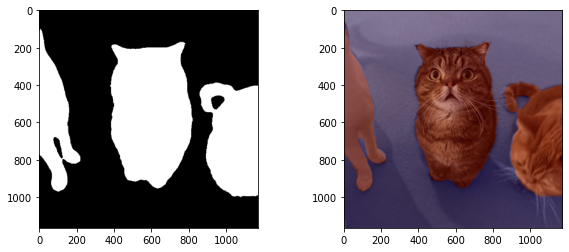

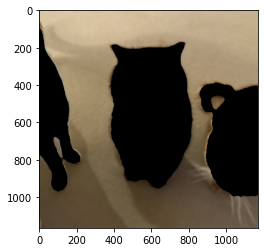

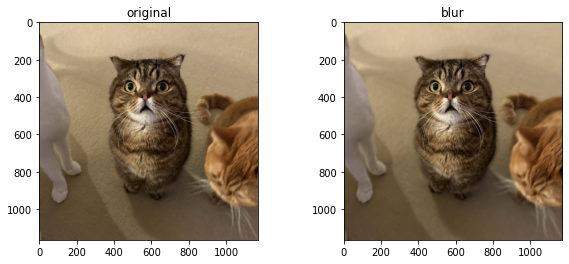

In [5]:
img_path = 'cat1.jpg'
ori, mak = portrait(img_path, 'cat')
background_blur(ori, mak)

(665, 1170, 3)
background
cat
(665, 1170)


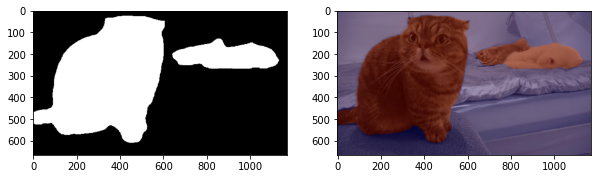

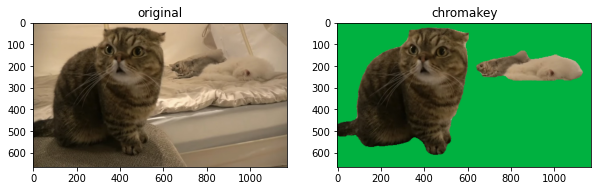

In [12]:
img_path = 'cat2.jpg'
ori, mak = portrait(img_path, 'cat')
bg_path = 'greenscreen.png'
background_chromakey(ori, mak, bg_path)

(665, 1062, 3)
background
cat
(665, 1062)


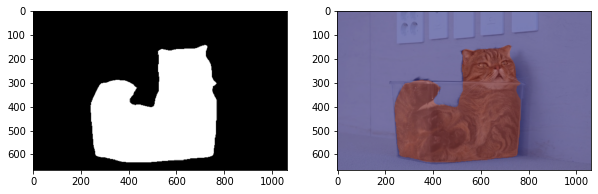

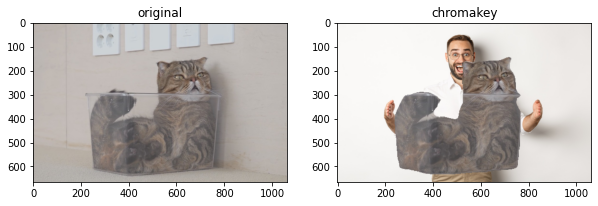

In [106]:
img_path = 'cat3.jpg'
ori, mak = portrait(img_path, 'cat')
bg_path = 'chromakey_bg2.jpg'
background_chromakey(ori, mak, bg_path)

(1474, 2560, 3)
background
train
(1474, 2560)


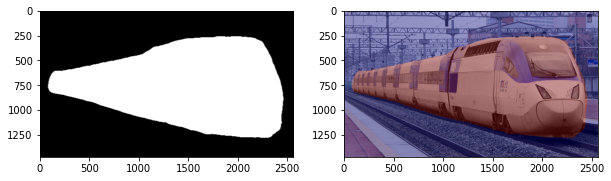

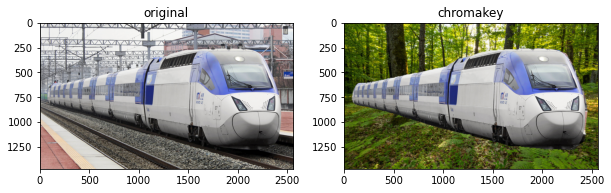

In [107]:
img_path = 'train1.jpg'
ori, mak = portrait(img_path, 'train')
bg_path = 'chromakey_bg1.jpg'
background_chromakey(ori, mak, bg_path)

(545, 620, 3)
background
person
train
(545, 620)


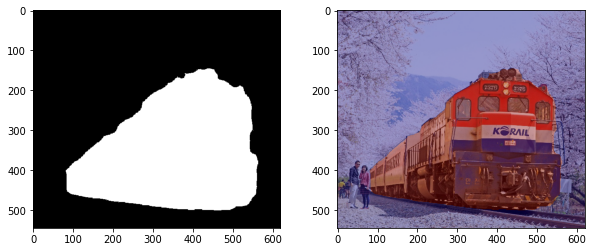

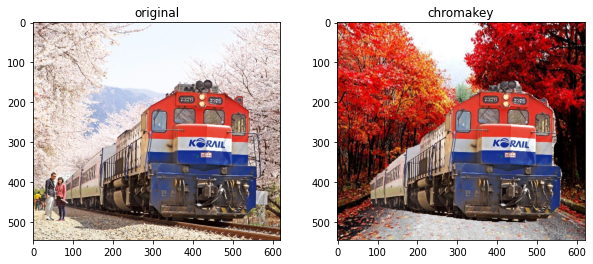

In [108]:
img_path = 'train2.jpg'
ori, mak = portrait(img_path, 'train')
bg_path = 'chromakey_bg3.jpg'
background_chromakey(ori, mak, bg_path)

(720, 534, 3)
background
chair
person
(720, 534)


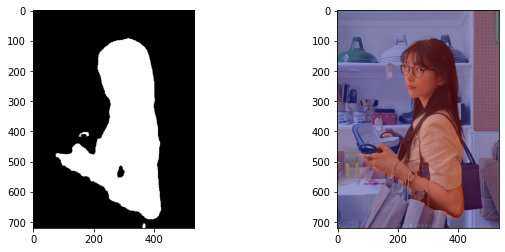

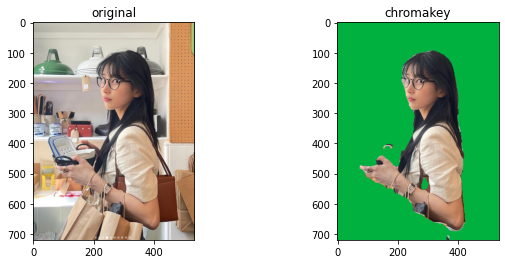

In [111]:
img_path = os.getenv('HOME')+'/aiffel/CV_Ex_Data/images/gls5.jpg'
ori, mak = portrait(img_path, 'person')
bg_path = 'greenscreen.png'
background_chromakey(ori, mak, bg_path)

(639, 600, 3)
background
bottle
person
(639, 600)


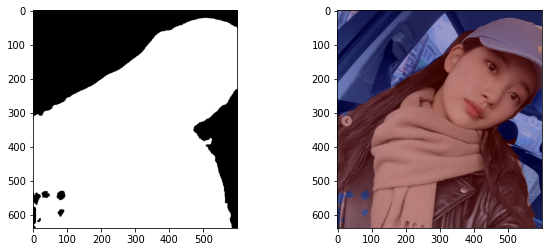

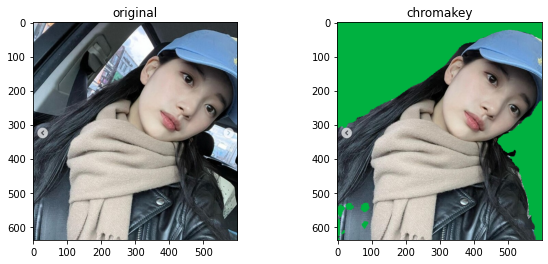

In [113]:
img_path = os.getenv('HOME')+'/aiffel/CV_Ex_Data/images/cap1.jpg'
ori, mak = portrait(img_path, 'person')
bg_path = 'greenscreen.png'
background_chromakey(ori, mak, bg_path)

(670, 649, 3)
background
car
chair
person
(670, 649)


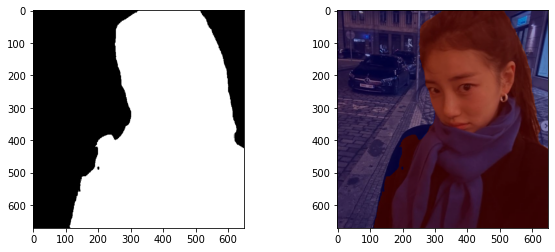

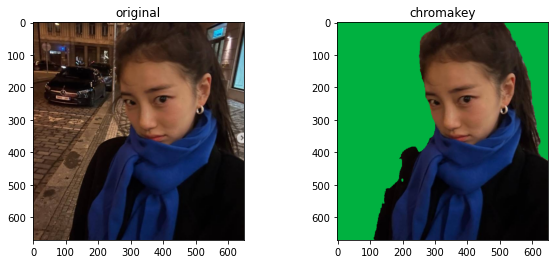

In [114]:
img_path = os.getenv('HOME')+'/aiffel/CV_Ex_Data/images/test2.jpg'
ori, mak = portrait(img_path, 'person')
bg_path = 'greenscreen.png'
background_chromakey(ori, mak, bg_path)

(1440, 1080, 3)
background
bottle
person
(1440, 1080)


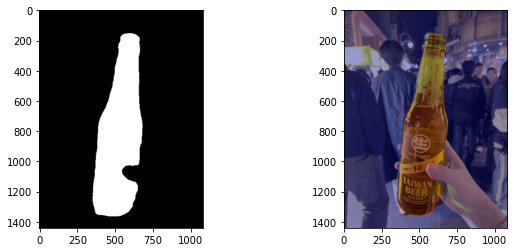

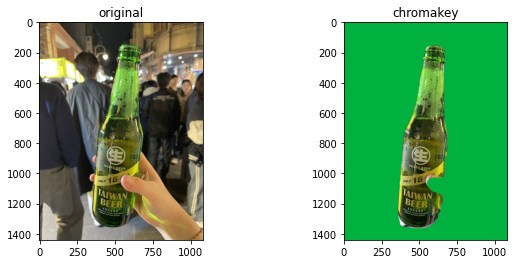

In [7]:
img_path = 'bottle1.jpg'
ori, mak = portrait(img_path, 'bottle')
bg_path = 'greenscreen.png'
background_chromakey(ori, mak, bg_path)

(1440, 1080, 3)
background
bottle
person
(1440, 1080)


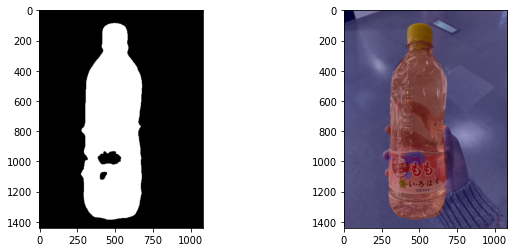

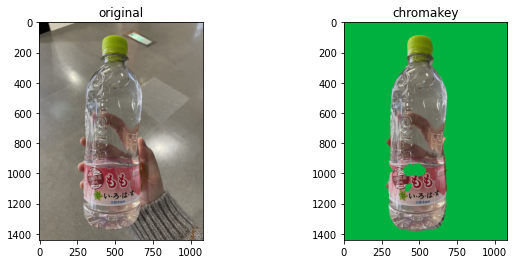

In [8]:
img_path = 'bottle2.jpg'
ori, mak = portrait(img_path, 'bottle')
bg_path = 'greenscreen.png'
background_chromakey(ori, mak, bg_path)

(365, 648, 3)
background
bottle
person
(365, 648)


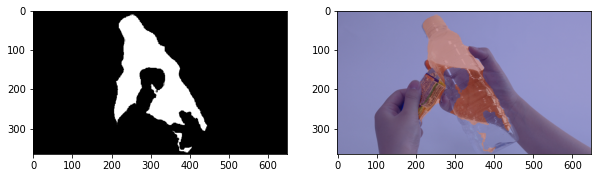

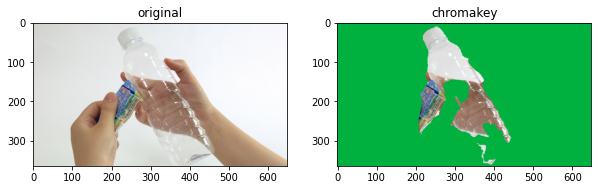

In [18]:
img_path = 'bottle3.jpg'
ori, mak = portrait(img_path, 'bottle')
bg_path = 'greenscreen.png'
background_chromakey(ori, mak, bg_path)

(1614, 1200, 3)
background
person
(1614, 1200)


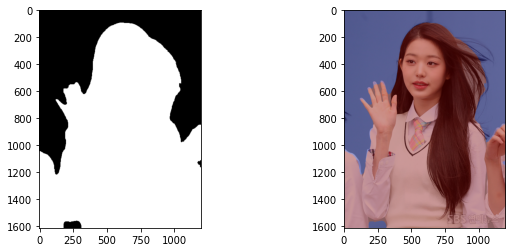

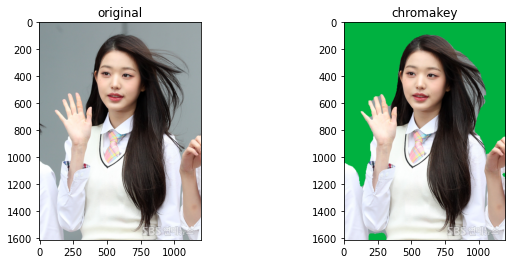

In [17]:
img_path = 'hair.jpg'
ori, mak = portrait(img_path, 'person')
bg_path = 'greenscreen.png'
background_chromakey(ori, mak, bg_path)

(250, 250, 3)
background
person
(250, 250)


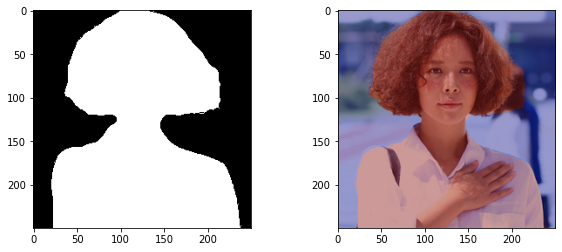

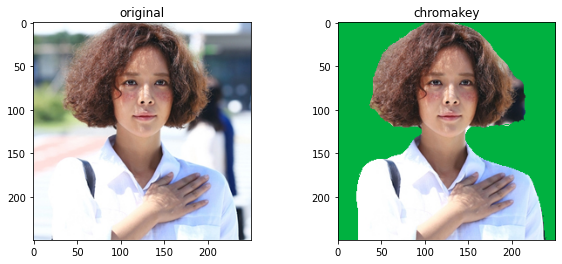

In [16]:
img_path = 'hair2.jpg'
ori, mak = portrait(img_path, 'person')
bg_path = 'greenscreen.png'
background_chromakey(ori, mak, bg_path)

## 문제점

- 같은 클래스여도 뒤에 있는 물체는 배경에 포함되어야 하는데 그렇지 않음

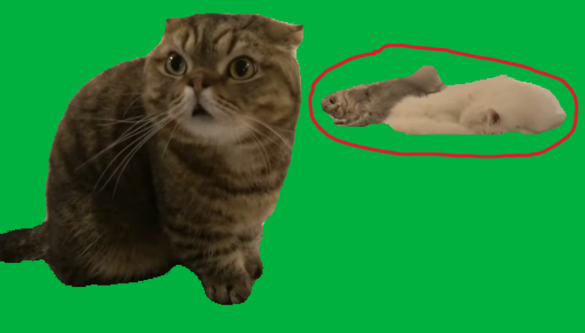

- 고양이의 수염, 머리카락과 같이 얇은 부분을 잘 처리하지 못함

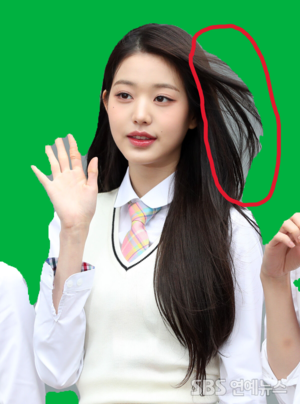

- 배경색이 물체의 색과 비슷하면 깔끔하게 누끼를 따지 못하거나 배경에 있는 물체까지 함께 인식됨

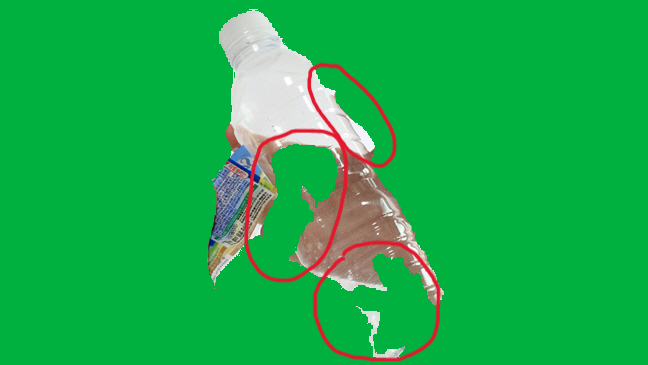

## 해결방법 제시
### 1. 물체의 가장자리 부분이 정교하지 못한 문제점을 Image Matting 기술을 적용하여 해결한다.
Image Matting이란?
- Foreground(전경)와 Background(배경)를 분리해내는 기술, 전경과 배경의 정교한 분리가 가능함.
- Segmentation 기술에 투명도를 의미하는 alpha channel을 추가한 것
- 일반적으로 전경, 배경, 가장자리로 이루어진 Trimap을 사용함.
- DIM(Deep Image Matting), MatteFormer, PP-Matting 등 딥러닝을 이용한 다양한 모델이 있다.

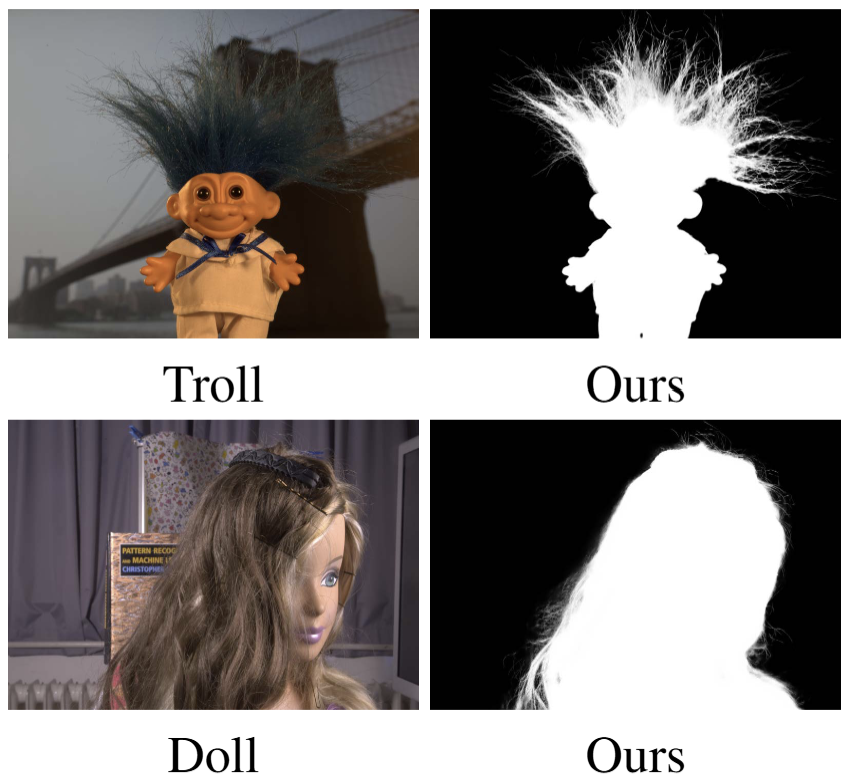

### 2. 이미지에 contrast(대비), Sharpness(선명도)를 강하게 적용하여 해결한다.
### - contrast

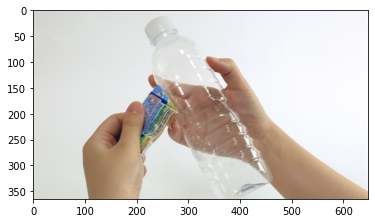

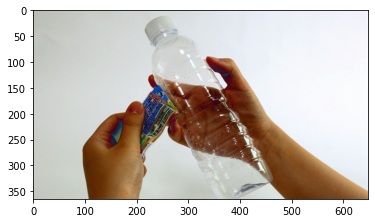

(365, 648, 3)
background
bottle
person
(365, 648)


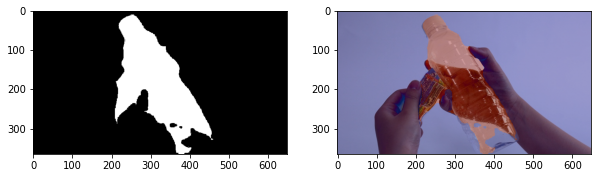

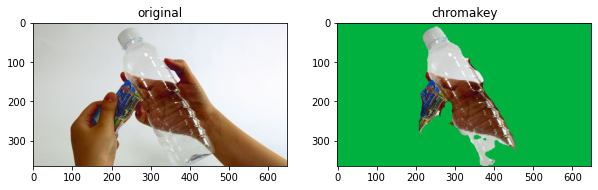

In [19]:
# 원본 이미지 불러오기
img_path = 'bottle3.jpg'
img_orig = cv2.imread(img_path) 
# contrast 적용
img_contrast = cv2.convertScaleAbs(img_orig * 1.5-128)
# 원본 이미지와 비교
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_contrast, cv2.COLOR_BGR2RGB))
plt.show()
# segmentation 수행
cv2.imwrite('./result/'+img_path, img_contrast)
ori, mak = portrait('./result/'+img_path, 'bottle')
bg_path = 'greenscreen.png'
background_chromakey(ori, mak, bg_path)

### - Sharpness

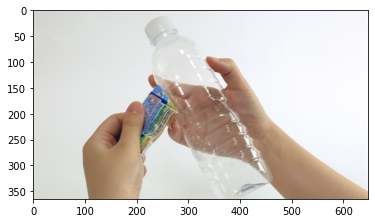

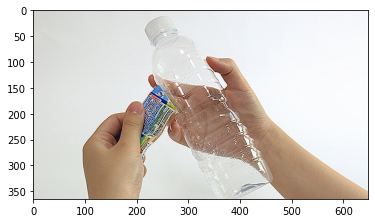

(365, 648, 3)
background
bottle
person
(365, 648)


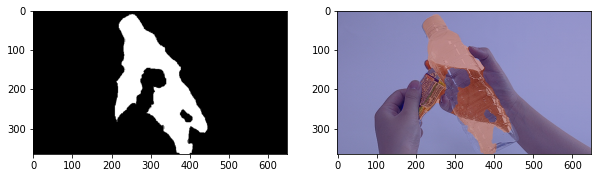

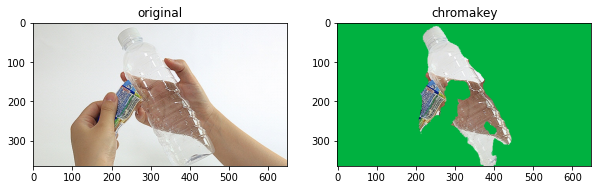

In [25]:
# 원본 이미지 불러오기
img_path = 'bottle3.jpg'
img_orig = cv2.imread(img_path) 
# sharpness 적용
sharp_kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
img_sharp = cv2.filter2D(img_orig, -1, sharp_kernel)
# 원본 이미지와 비교
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_sharp, cv2.COLOR_BGR2RGB))
plt.show()
# segmentation 수행
cv2.imwrite('./result/'+img_path, img_sharp)
ori, mak = portrait('./result/'+img_path, 'bottle')
bg_path = 'greenscreen.png'
background_chromakey(ori, mak, bg_path)

### - contrast + Sharpness

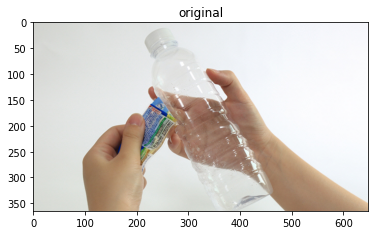

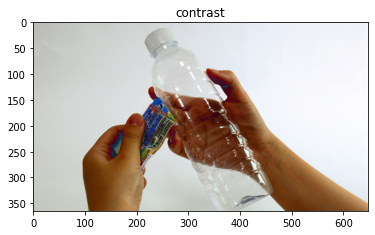

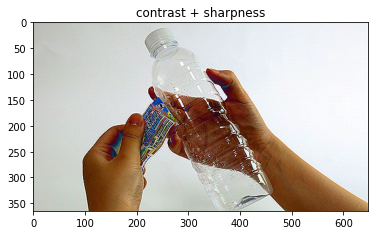

(365, 648, 3)
background
bottle
person
(365, 648)


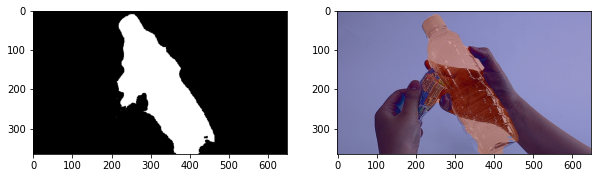

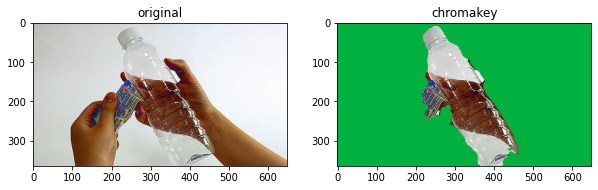

In [28]:
# 원본 이미지 불러오기
img_path = 'bottle3.jpg'
img_orig = cv2.imread(img_path)
# contrast + sharpness 적용
img_contrast = cv2.convertScaleAbs(img_orig * 1.5-128)
sharp_kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
img_sharp = cv2.filter2D(img_contrast, -1, sharp_kernel)
# 원본 이미지와 비교
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title("original")
plt.show()
plt.imshow(cv2.cvtColor(img_contrast, cv2.COLOR_BGR2RGB))
plt.title("contrast")
plt.show()
plt.imshow(cv2.cvtColor(img_sharp, cv2.COLOR_BGR2RGB))
plt.title("contrast + sharpness")
plt.show()
# segmentation 수행
cv2.imwrite('./result/'+img_path, img_sharp)
ori, mak = portrait('./result/'+img_path, 'bottle')
bg_path = 'greenscreen.png'
background_chromakey(ori, mak, bg_path)

contrast와 sharpness 값을 얼마나 적용할지에 대해서는 조금 더 조정하며 실험을 해봐야 겠지만 DeepLab의 semantic segmentation만 적용했을 때의 결과와 비교해보면 훨씬 좋은 성능을 보이는 것 같다.
- DeepLab의 semantic segmentation만 적용한 이미지

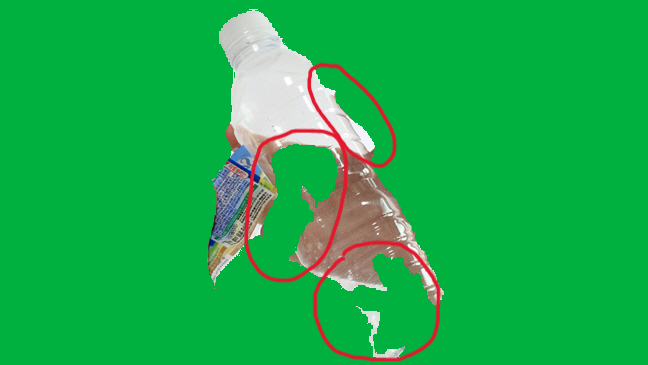

## 실제 기업에서 쓰고 있는 방법
### 1. 듀얼 카메라를 이용한 DepthMap 만들기

- 두 카메라로 촬영된 이미지에서 동일 점 사이의 거리를 계산하여 시차를 구할 수 있고 이 시차를 이용하여 깊이맵을 추정할 수 있다.
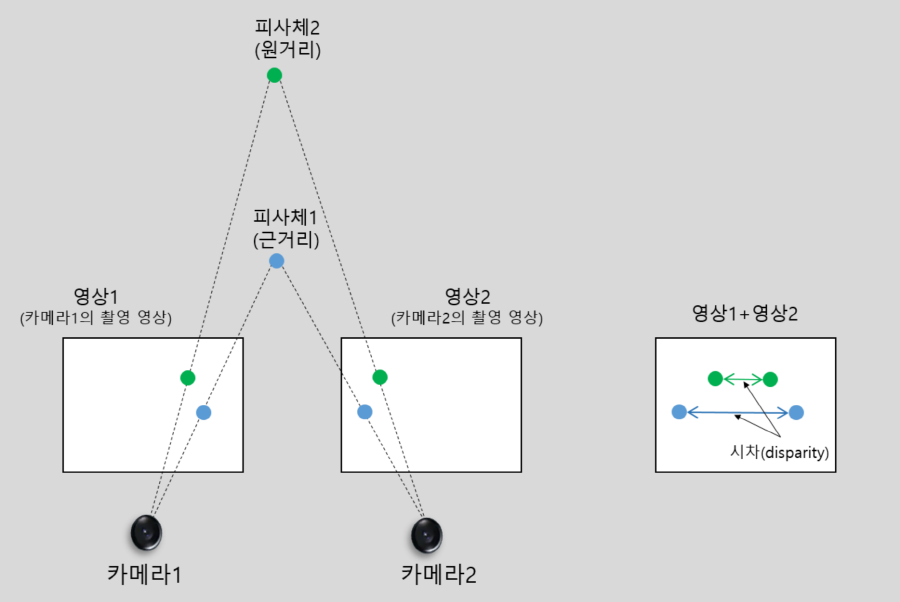

- 추정한 깊이 맵을 기반으로 초점을 맞춘 피사체와 가까운 거리는 약한 강도의 흐림 효과를 적용하고, 먼 거리는 강한 강도의 흐림 효과를 적용.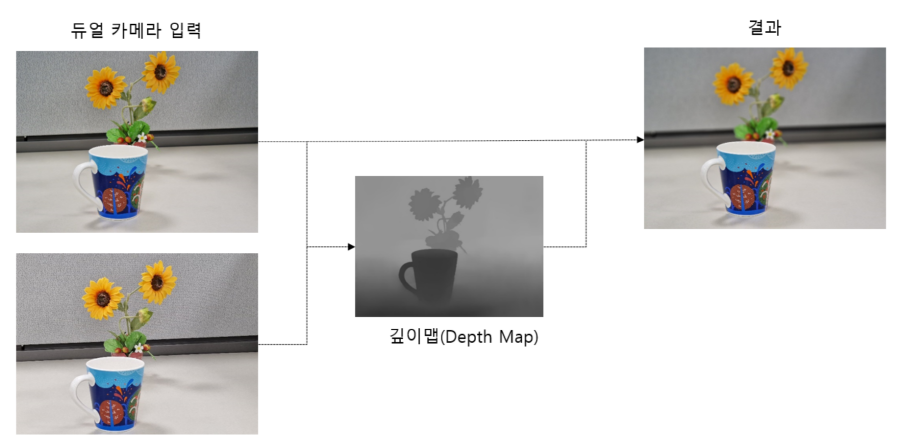

https://r2.community.samsung.com/t5/CamCyclopedia/%EC%9D%B8%EB%AC%BC%EC%82%AC%EC%A7%84/ba-p/12662571

### 2. LiDAR 센서를 이용한 심도 측정
- 라이다 스캐너에서 사물에 레이저(빛 펄스)를 쏘고 빛이 반사되어서 돌아오는 시간을 측정해서 거리와 깊이를 알아냄.
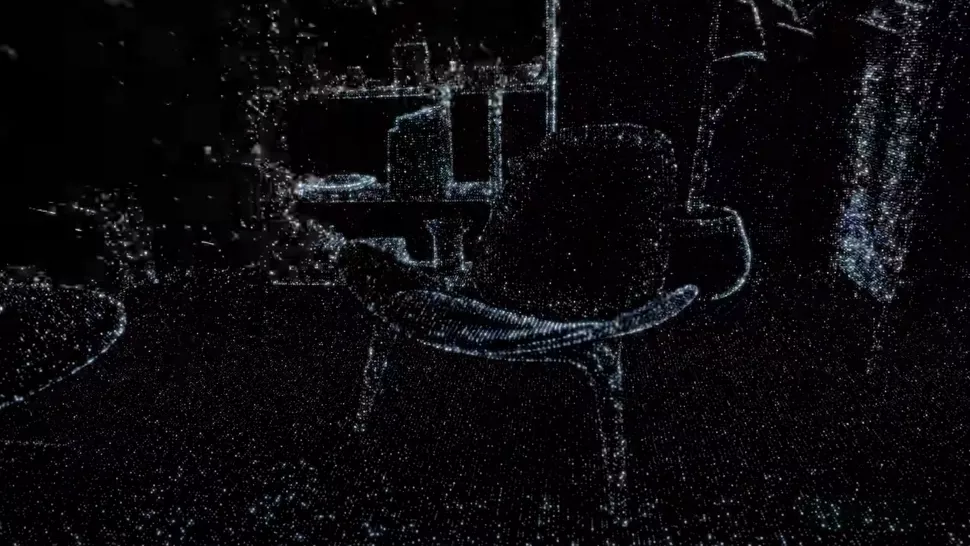

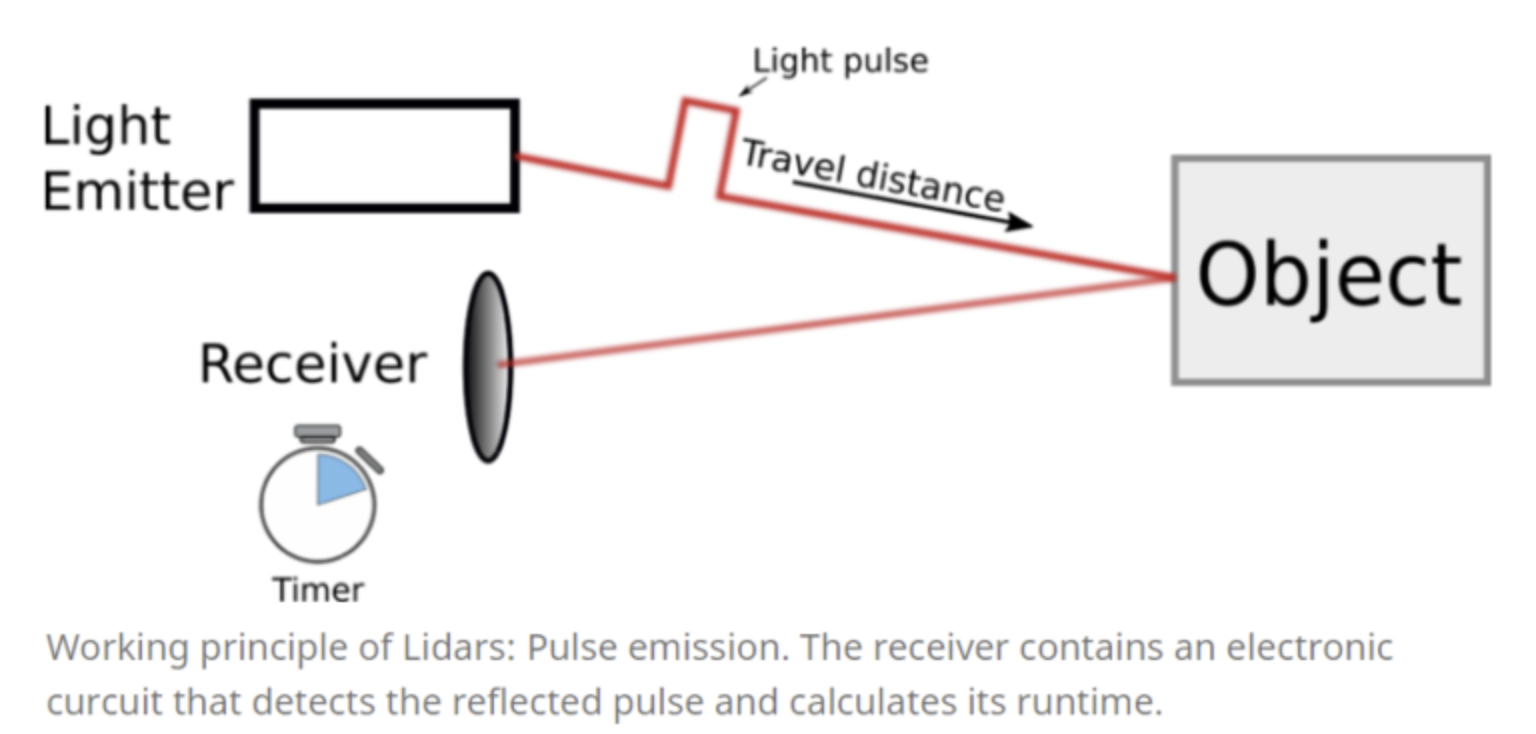

https://bahns.net/iphone-12-pro-lidar

### 3.ToF를 이용한 심도 측정
- 라이다 센서와 비슷하게 빛이 물체에 닿았다가 반사되어 돌아오는 시간을 측정한다. 신호의 위상 차이를 계산해 거리를 구한다는 점이 다르다.
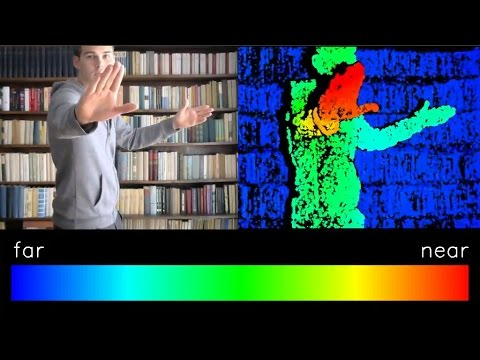

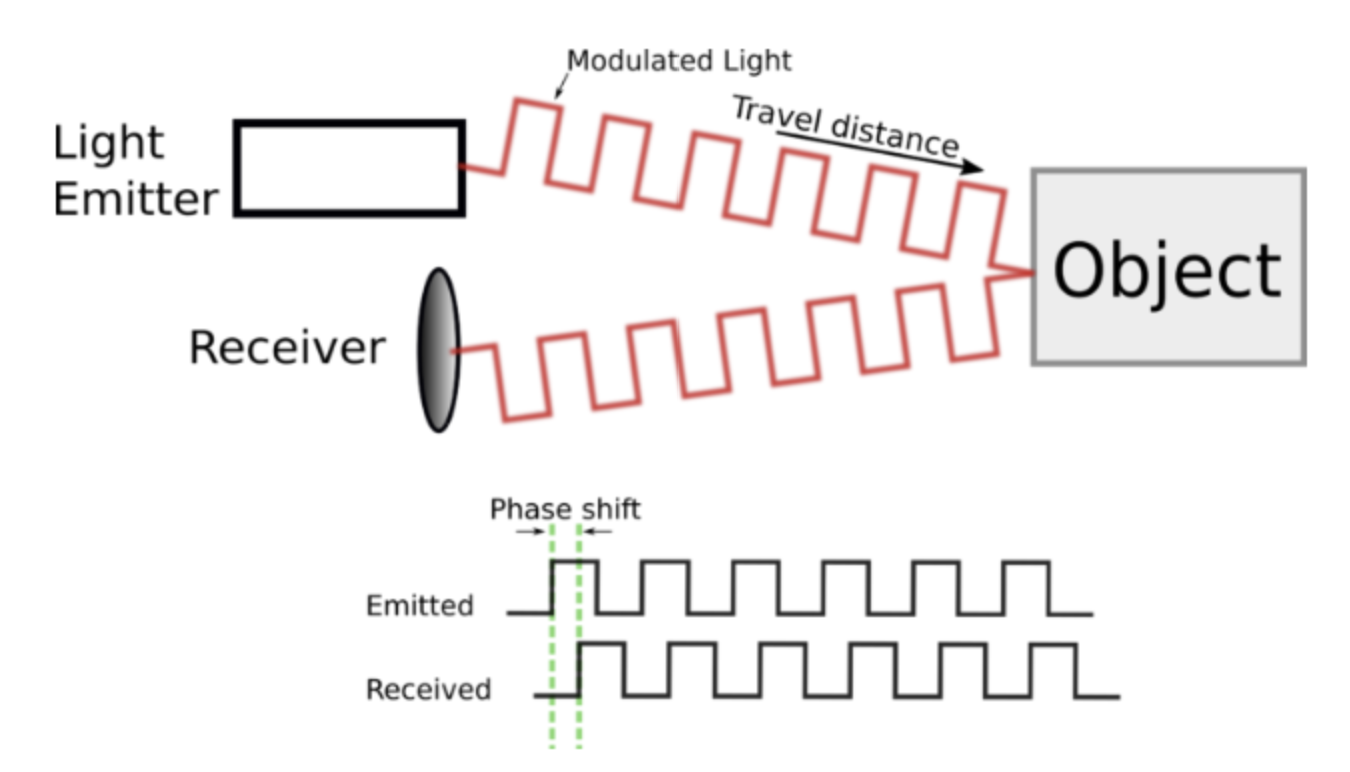

https://m.blog.naver.com/jkhan012/222002066872